# Simulating SNe II discovered by LSST

### Modified from previous work done by Thomas de Jaeger in [de Jaeger et al. 2017](http://adsabs.harvard.edu/abs/2017ApJ...835..166D)

In [1]:
import math
from scipy import integrate
from scipy import interpolate
from numpy import vectorize
import numpy as np
import matplotlib.pyplot as plt
#from matplotlib.pyplot import *
import pandas as pd

In [2]:
c_light=299792.458 # in km/s
c_AA=299792458*1.0e10#in AA/s
alpha_IMF=1.35     # Salpeter IMF: Salpeter et al. 1955 ApJ 121: 161
z_max=1.2          # input('Givea value of the maximum redshift used :')
fow_LSST=9.6       # field of view LSST in degrees (*60 in arcmin)
delta_omega=fow_LSST*1.0/pow((180/math.pi),2)      # field of view LSST in str
# calculating for r-band -> http://smtn-002.lsst.io/en/latest/
mag_lim=24.38      # input('Give a value for limit magnitude ') # apparent magnitde limit for the LSST   
h_erg = 6.63e-27 #Plancks constant (erg.s)
h = 0.70           # dimensionless Hubble constant
H0 = 100.0 * h     # Hubble constant in Km/s/Mpc
d_h=c_light*1.0/H0 # Hubble distance in Mpc   (70 km/s / Mpc)

#cosmology
omega_m=0.30
omega_k=0.0
omega_lambda=0.70
#omega_m_2=1.0  # Dark matter density for standard model
#omega_k_2=0.     #Universe curvature for standard model
#omega_lambda_2=0.0 #Dark energy density for standard model

In [3]:
def e_z_distri(z):
    return (1.0/math.sqrt(omega_m*((1+z)**3)+ omega_k*((1+z)**2) + omega_lambda))
    e_z_int, e_z_int_err = integrate.quad(e_z_distri,0.,z)

def r_com_distri(z):                   # We define comoving distance for flat universe in Mpc
    return (d_h*integrate.quad(e_z_distri,0.,z)[0])

def d_lum_distri(z):                   # We define luminosity distance for flat universe in Mpc
    return (r_com_distri(z)*(1+z))

def d_mod_distri(z):                   # We define modulus distance for flat universe
    return (5.0 * np.log10(d_lum_distri(z)*10**6/10))

def madau_time(t):                   # We define t9 as Madeau et al 1998
    return (13*pow((1+t),-1.5))

def salpeter(M):
    return (pow(M,-(1+alpha_IMF)))
def Mass_tot(M):
    return (pow(M,-alpha_IMF))

a=3.4
b=-0.3
c=-3.5
ro=0.016*0.73
eta=-10
B=2**(1-a/b)
C=2**((b-a)/c)*5**(1-b/c)
def SFR_Horiuchi(z):
    return (ro*((1+z)**(a*eta)+((1+z)*1.0/B)**(b*eta)+((1+z)*1.0/C)**(c*eta))**(-0.1))

def SNR_Horiuchi(z):
    return (IMF*SFR_Horiuchi(z))

a1=0.0166 
b1=0.1848 
c1=1.9474 
d1=2.6316 
def SFR_Cole(z):
    return (h*(a1+b1*z)/(1+(z/c1)**d1))

def SNR_Cole(z):
    return (IMF*SFR_Cole(z))   

def dust(z):
    if z<3.3:
        f_dust=0.95-0.28*z
    else:
        f_dust=0.02
    return f_dust 

def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return array[idx]

def e_z_LCDM(z):
    return (1.0/math.sqrt(omega_m*((1+z)**3)+ omega_k*((1+z)**2) + omega_lambda))
    e_z_int_LCDM, e_z_int_err_LCDM = integrate.quad(e_z_LCDM,0.,z)

def r_com_LCDM(z):                   # We define comoving distance for flat universe in Mpc
    return (d_h*integrate.quad(e_z_LCDM,0.,z)[0])

def d_lum_LCDM(z):                   # We define luminosity distance for flat universe in Mpc
    return (r_com_LCDM(z)*(1+z))

def mu_LCDM(z):                   # We define modulus distance for flat universe
    return (5.0 * np.log10(d_lum_LCDM(z)*10**6/10))

In [4]:
# Calculating IMF

mass_min=8
mass_max=50

IMF=integrate.quad(salpeter,mass_min,mass_max)[0]/(integrate.quad(Mass_tot,0.1,100))[0] #number of stars with M>8Msol

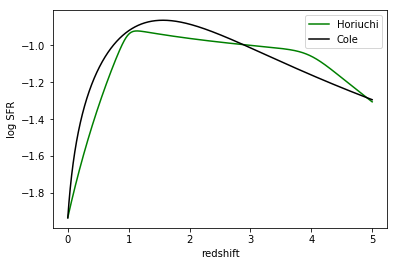

In [5]:
# Calculating SFR
#
#Horiuchi et al. 2011 ApJ, 738, 154H
#Cole et al. 2001  MNRAS, 326, 255C
         
SFR_Horiuchi_vect=vectorize(SFR_Horiuchi)
SFR_Cole_vect=vectorize(SFR_Cole)

z_sfr=np.arange(0,5,0.001)
plt.plot(z_sfr,np.log10(SFR_Horiuchi_vect(z_sfr)),'g',z_sfr,np.log10(SFR_Cole_vect(z_sfr)),'k')
plt.legend(('Horiuchi','Cole'))
plt.xlabel('redshift')
plt.ylabel('log SFR')
plt.show()

### LSST filters from https://github.com/lsst/throughputs/tree/master/baseline

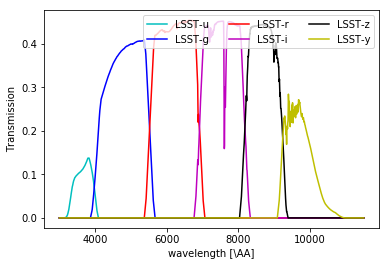

In [6]:
trans_u=np.loadtxt('total_u.dat')
lambda_filter=trans_u[:,0]*10      #in AA
s_u=trans_u[:,1]
trans_g=np.loadtxt('total_g.dat')
s_g=trans_g[:,1] 
trans_r=np.loadtxt('total_r.dat')
s_r=trans_r[:,1]
trans_i=np.loadtxt('total_i.dat')
s_i=trans_i[:,1]
trans_z=np.loadtxt('total_z.dat')
s_z=trans_z[:,1] 
trans_y=np.loadtxt('total_y.dat')
s_y=trans_y[:,1] 

u_func=interpolate.interp1d(lambda_filter,s_u)
g_func=interpolate.interp1d(lambda_filter,s_g)
r_func=interpolate.interp1d(lambda_filter,s_r)
i_func=interpolate.interp1d(lambda_filter,s_i)
z_func=interpolate.interp1d(lambda_filter,s_z)
y_func=interpolate.interp1d(lambda_filter,s_y)

dem_u=integrate.simps(u_func(lambda_filter)*1.0/lambda_filter,lambda_filter) 
dem_g=integrate.simps(g_func(lambda_filter)*1.0/lambda_filter,lambda_filter) 
dem_r=integrate.simps(r_func(lambda_filter)*1.0/lambda_filter,lambda_filter) 
dem_i=integrate.simps(i_func(lambda_filter)*1.0/lambda_filter,lambda_filter) 
dem_z=integrate.simps(z_func(lambda_filter)*1.0/lambda_filter,lambda_filter) 
dem_y=integrate.simps(y_func(lambda_filter)*1.0/lambda_filter,lambda_filter) 

plt.plot(lambda_filter,s_u,'c',lambda_filter,s_g,'b',lambda_filter,s_r,'r',lambda_filter,s_i,'m',lambda_filter,s_z,'k',lambda_filter,s_y,'y')
plt.legend(('LSST-u','LSST-g','LSST-r','LSST-i','LSST-z','LSST-y'),loc=1,markerscale=0.5,prop={'size':10},ncol=3) 
plt.xlabel('wavelength [\AA]')
plt.ylabel('Transmission')
plt.show()


### Use [Dessart et al. 2013](http://esoads.eso.org/abs/2013MNRAS.433.1745D) models for K-corrections

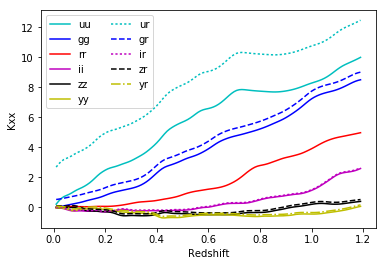

In [7]:
#take Dessart' model 50 days after explosion
Model=[str('m15_du_sch_mlt3_FeC_mix0p4_18.fl')] #_LR_1500_50000.fl')]
epoque_model=51
txt=np.loadtxt('m15mlt3/%s'%Model[0]).transpose()

#rest frame
lambda_model=(txt[0])
flux_model=(txt[1])
F_spec_model_0=interpolate.interp1d(lambda_model,flux_model)


#grille redshift
z_sim=np.arange(0.01,z_max,0.01)
K_uu=np.zeros(len(z_sim))
K_gg=np.zeros(len(z_sim))
K_rr=np.zeros(len(z_sim))
K_ii=np.zeros(len(z_sim))
K_zz=np.zeros(len(z_sim))
K_yy=np.zeros(len(z_sim))
K_ur=np.zeros(len(z_sim))
K_gr=np.zeros(len(z_sim))
K_ir=np.zeros(len(z_sim))
K_zr=np.zeros(len(z_sim))
K_yr=np.zeros(len(z_sim))
for  i in range(len(z_sim)):
    lambda_model_obs=lambda_model*(1+z_sim[i])
    flux_model_obs=flux_model*1.0/(1+z_sim[i])
    F_spec_model_z=interpolate.interp1d(lambda_model_obs,flux_model_obs)
    
    #comparison of F_spec_model_z and F_spec_model_0
    n_lsst_u=integrate.simps(F_spec_model_z(lambda_filter)*u_func(lambda_filter)*lambda_filter,lambda_filter)   
    n_lsst_g=integrate.simps(F_spec_model_z(lambda_filter)*g_func(lambda_filter)*lambda_filter,lambda_filter)   
    n_lsst_r=integrate.simps(F_spec_model_z(lambda_filter)*r_func(lambda_filter)*lambda_filter,lambda_filter)   
    n_lsst_i=integrate.simps(F_spec_model_z(lambda_filter)*i_func(lambda_filter)*lambda_filter,lambda_filter)   
    n_lsst_z=integrate.simps(F_spec_model_z(lambda_filter)*z_func(lambda_filter)*lambda_filter,lambda_filter)   
    n_lsst_y=integrate.simps(F_spec_model_z(lambda_filter)*y_func(lambda_filter)*lambda_filter,lambda_filter)   
    m_lsst_u_z=-2.5*(np.log10(n_lsst_u/dem_u))-48.60+2.5*(np.log10(c_AA))
    m_lsst_g_z=-2.5*(np.log10(n_lsst_g/dem_g))-48.60+2.5*(np.log10(c_AA))
    m_lsst_r_z=-2.5*(np.log10(n_lsst_r/dem_r))-48.60+2.5*(np.log10(c_AA))
    m_lsst_i_z=-2.5*(np.log10(n_lsst_i/dem_i))-48.60+2.5*(np.log10(c_AA))
    m_lsst_z_z=-2.5*(np.log10(n_lsst_z/dem_z))-48.60+2.5*(np.log10(c_AA))
    m_lsst_y_z=-2.5*(np.log10(n_lsst_y/dem_y))-48.60+2.5*(np.log10(c_AA))

    #Comparison of F_spec_model_z(SDSS) and F_spec_model_0(CSP)
    n_lsst_u=integrate.simps(F_spec_model_0(lambda_filter)*u_func(lambda_filter)*lambda_filter,lambda_filter)   
    n_lsst_g=integrate.simps(F_spec_model_0(lambda_filter)*g_func(lambda_filter)*lambda_filter,lambda_filter)   
    n_lsst_r=integrate.simps(F_spec_model_0(lambda_filter)*r_func(lambda_filter)*lambda_filter,lambda_filter)   
    n_lsst_i=integrate.simps(F_spec_model_0(lambda_filter)*i_func(lambda_filter)*lambda_filter,lambda_filter)   
    n_lsst_z=integrate.simps(F_spec_model_0(lambda_filter)*z_func(lambda_filter)*lambda_filter,lambda_filter)   
    n_lsst_y=integrate.simps(F_spec_model_0(lambda_filter)*y_func(lambda_filter)*lambda_filter,lambda_filter)   
    m_lsst_u_0=-2.5*(np.log10(n_lsst_u/dem_u))-48.60+2.5*(np.log10(c_AA))
    m_lsst_g_0=-2.5*(np.log10(n_lsst_g/dem_g))-48.60+2.5*(np.log10(c_AA))
    m_lsst_r_0=-2.5*(np.log10(n_lsst_r/dem_r))-48.60+2.5*(np.log10(c_AA))
    m_lsst_i_0=-2.5*(np.log10(n_lsst_i/dem_i))-48.60+2.5*(np.log10(c_AA))
    m_lsst_z_0=-2.5*(np.log10(n_lsst_z/dem_z))-48.60+2.5*(np.log10(c_AA))
    m_lsst_y_0=-2.5*(np.log10(n_lsst_y/dem_y))-48.60+2.5*(np.log10(c_AA))

    K_uu[i]=m_lsst_u_z-m_lsst_u_0
    K_gg[i]=m_lsst_g_z-m_lsst_g_0
    K_rr[i]=m_lsst_r_z-m_lsst_r_0
    K_ii[i]=m_lsst_i_z-m_lsst_i_0
    K_zz[i]=m_lsst_z_z-m_lsst_z_0
    K_yy[i]=m_lsst_y_z-m_lsst_y_0
    #
    K_ur[i]=m_lsst_u_z-m_lsst_r_0
    K_gr[i]=m_lsst_g_z-m_lsst_r_0
    K_ir[i]=m_lsst_i_z-m_lsst_r_0
    K_zr[i]=m_lsst_z_z-m_lsst_r_0
    K_yr[i]=m_lsst_y_z-m_lsst_r_0

Kuu_func=interpolate.interp1d(z_sim,K_uu)
Kgg_func=interpolate.interp1d(z_sim,K_gg)
Krr_func=interpolate.interp1d(z_sim,K_rr)
Kii_func=interpolate.interp1d(z_sim,K_ii)
Kzz_func=interpolate.interp1d(z_sim,K_zz)
Kyy_func=interpolate.interp1d(z_sim,K_yy)
#
Kur_func=interpolate.interp1d(z_sim,K_ur)
Kgr_func=interpolate.interp1d(z_sim,K_gr)
Kir_func=interpolate.interp1d(z_sim,K_ir)
Kzr_func=interpolate.interp1d(z_sim,K_zr)
Kyr_func=interpolate.interp1d(z_sim,K_yr)

plt.plot(z_sim,K_uu,'c',z_sim,K_gg,'b',z_sim,K_rr,'r',z_sim,K_ii,'m',z_sim,K_zz,'k',z_sim,K_yy,'y', z_sim,K_ur,'c:',z_sim,K_gr,'b--',z_sim,K_ir,'m:',z_sim,K_zr,'k--',z_sim,K_yr,'y-.')
plt.xlabel('Redshift')
plt.ylabel('Kxx')
plt.legend(('uu','gg','rr','ii','zz','yy','ur','gr','ir','zr','yr'),loc=2,markerscale=0.5,prop={'size':10},ncol=2) 
plt.show()


In [8]:
### Effect of Dust

####### Lambda effective

txt=pd.read_table('m15mlt3/m15_du_sch_mlt3_FeC_mix0p4_list',delim_whitespace=True,header=None)
Model=txt[0].values
epoque_model=txt[1].values

lam=len(epoque_model)*[0]
flux_model=len(epoque_model)*[0]

for  i in range(len(Model)):
    txt=np.loadtxt('m15mlt3/'+Model[i]+'.fl').transpose()
    lam[i]=(txt[0])
    flux_model[i]=(txt[1])*1*10**8

In [9]:
dem_r=integrate.simps(r_func(lambda_filter)*1.0/lambda_filter,lambda_filter) 


num=np.zeros(shape=(len(epoque_model),len(z_sim)))
m_sn_model=np.zeros(shape=(len(epoque_model),len(z_sim)))
for i in range(len(epoque_model)):
    for t in range(len(z_sim)):
        dem=4*math.pi*(d_lum_distri(z_sim[t])*1.0e6)**2      #4pi*dL(z) where dL is in cm
        lambda_model_obs=lam[i]*(1+z_sim[t])
        flux_model_obs=flux_model[i]*1.0/(1+z_sim[t])
        F_spec_model_z=interpolate.interp1d(lambda_model_obs,flux_model_obs)
        num[i,t]=integrate.simps(F_spec_model_z(lambda_filter)*r_func(lambda_filter)*lambda_filter,lambda_filter)*1.0/dem
        m_sn_model[i,t]=-2.5*np.log10((num[i,t]/dem_r))-48.60+2.5*(np.log10(c_AA))-1.086*np.log10(dust(z_sim[t]))

### example with  SN 2005J

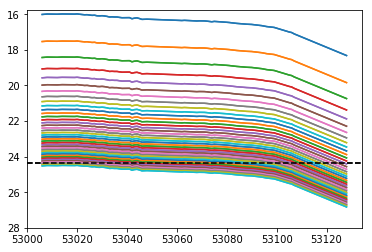

[ 0.01  0.02  0.03  0.04  0.05  0.06  0.07  0.08  0.09  0.1   0.11  0.12
  0.13  0.14  0.15  0.16  0.17  0.18  0.19  0.2   0.21  0.22  0.23  0.24
  0.25  0.26  0.27  0.28  0.29  0.3   0.31  0.32  0.33  0.34  0.35  0.36
  0.37  0.38  0.39  0.4 ]


In [11]:

JD_explosion=2453382.78
JD_ref=2453000
z_cmb=4183.*1.0/c_light
err_z_cmb=150.*1.0/c_light
SN_photo=np.loadtxt('05J/sn2005j.out_r_swope').transpose()
SN_epoch=SN_photo[0][SN_photo[1]!=999.0]+JD_ref-JD_explosion
mag_r=SN_photo[1][SN_photo[1]!=999.0]
dmag_r=SN_photo[2][SN_photo[1]!=999.0]

M_SN_r=mag_r-5*np.log10(d_lum_distri(z_cmb))-25
dM_SN_r=np.sqrt(dmag_r**2+(np.array(err_z_cmb)*(5*(1+np.array(z_cmb))*1.0/(np.array(z_cmb)*(1+np.array(z_cmb)*1.0/2)*np.log10(10))))**2)

m_sn=np.zeros(shape=(len(SN_epoch),len(z_sim)))
for i in range(len(SN_epoch)):
    for t in range(len(z_sim)):
        m_sn[i,t]=M_SN_r[i]+d_mod_distri(z_sim[t])

plt.plot(SN_epoch,m_sn[:,0:40]) #M_SN_r,)#
#plt.ylim(max(m_sn[:,0])+0.2,min(m_sn[:,0])-0.2)
plt.ylim(28.,min(m_sn[:,0])-0.2)
plt.axhline(mag_lim, color='k', linestyle='--')

plt.show()
print(z_sim[0:40])

### We now compare our m(time,z) with m_lim of the camera to obtain delta_t(z)

In [12]:
t_min=[0]*len(z_sim)
t_max=[0]*len(z_sim)
t_max_2=[0]*len(z_sim)
delta_t_redshift=[0]*len(z_sim) #delta t corrected by redshift
epoque_model_z=[0]*len(SN_epoch)

for i in range(len(z_sim)):
    epoque_model_z=SN_epoch*(1+z_sim[i])  #1+z for the time
    if min(m_sn[:,i][:])<mag_lim:
        t_min[i]=epoque_model_z[min(np.where(m_sn[:,i]<=mag_lim)[0])]
        o=set(np.where(epoque_model_z>=t_min[i])[0])#index where last t>t_min
        p=set(np.where(m_sn[:,i]<=mag_lim)[0])#index where we see the SN
        q=(list(o-p))#all the index where we see the pic of the shock breakout
        if q==[]:
            t_max[i]=epoque_model_z[max(np.where(m_sn[:,i]<=mag_lim)[0])]
            delta_t_redshift[i]=t_max[i]-t_min[i]
        else:
            t_max[i]=epoque_model_z[min(q)]
            t_max_2[i]=epoque_model_z[max(q)]
            delta_t_redshift[i]=(t_max[i]-t_min[i])+(max(epoque_model_z)-t_max_2[i])#le SBO+ rest of curve

### Now the number of detected SNe II per unit of redshift (dN/dz)

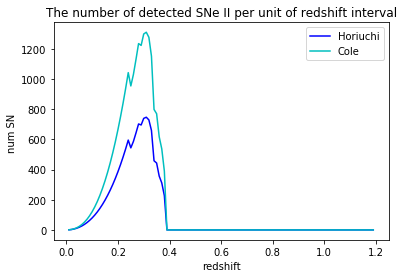

/Users/lluisgalbany/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


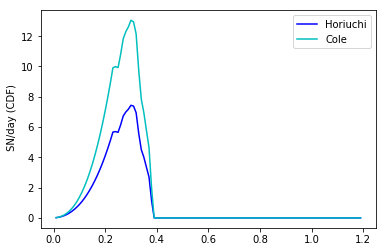

In [13]:
dV_dz_dW=np.zeros(len(z_sim))

# Madau model 1
dn_dz_Horiuchi=np.zeros(len(z_sim))  
n_Horiuchi=[0]*len(z_sim)

# Madau model 2
dn_dz_Cole=np.zeros(len(z_sim)) 
n_Cole=[0]*len(z_sim)

for i in range(len(z_sim)):
    dV_dz_dW[i]=(pow(r_com_distri(z_sim[i]),2)*d_h*e_z_distri(z_sim[i]))    #dV(z) is the volume per unit redshift being surveyed

    dn_dz_Horiuchi[i]=(SNR_Horiuchi(z_sim[i])*1.0/(1+z_sim[i])*dV_dz_dW[i]*delta_omega)#dn/dz is the SN per unit of redshift, comovil volume, solid angle and fied of view
    dn_dz_Cole[i]=(SNR_Cole(z_sim[i])*1.0/(1+z_sim[i])*dV_dz_dW[i]*delta_omega)#dn/dz is the SN per unit of redshift, comovil volume, solid anfle and fied of view

    n_Horiuchi[i]=dn_dz_Horiuchi[i]*((delta_t_redshift[i])*1.0/365.25) #In yr (SNR in yr)
    n_Cole[i]=dn_dz_Cole[i]*((delta_t_redshift[i])*1.0/365.25)
                               
plt.plot(z_sim,n_Horiuchi,'b',z_sim,n_Cole,'c')
plt.title('The number of detected SNe II per unit of redshift interval')
plt.xlabel('redshift')
plt.ylabel('num SN ')
plt.legend(('Horiuchi','Cole'))
plt.show()


# We integrate for all the redshift to have the number of SN 
n_func_Horiuchi=interpolate.interp1d(z_sim,n_Horiuchi)
n_supernova_Horiuchi=integrate.quad(n_func_Horiuchi,min(z_sim),max(z_sim))[0]

n_func_Cole=interpolate.interp1d(z_sim,n_Cole)
n_supernova_Cole=integrate.quad(n_func_Cole,min(z_sim),max(z_sim))[0]


# number of SN versus redshift!!
bin_int=np.arange(0.01,max(z_sim)+0.01,0.01)
n_supernova_Horiuchi=[0]*(len(z_sim))
n_supernova_Cole=[0]*(len(z_sim))

for i in range(len(z_sim)-1):
    n_supernova_Horiuchi[i]=integrate.quad(n_func_Horiuchi,bin_int[i],bin_int[i+1])[0]
    n_supernova_Cole[i]=integrate.quad(n_func_Cole,bin_int[i],bin_int[i+1])[0]

plt.plot(z_sim,n_supernova_Horiuchi,'b',z_sim,n_supernova_Cole,'c')
plt.ylabel(' SN/day (CDF)')
plt.legend(('Horiuchi','Cole'))
plt.show()


### Now instead of taking 05J as an example, we simulated with MCMC 1000 SNe II from real parameters of a sample of CSP SNe II 

In [14]:
##simulation file:
MC_var=np.loadtxt('mc_var.dat').transpose()

Mabs_V_MC=MC_var[0] #M at the end of the plateau
s2_MC=MC_var[1]     #slope of the plateau
B_V_MC=MC_var[2]    #color at the end of the plateau
Pd_MC=MC_var[3]     #plateau duration

In [ ]:
#Random selection
N_SNe=5000
# SNe index
ind_tot=np.arange(0,len(s2_MC),1)
ind_SNe=np.random.choice(np.array(ind_tot)[(np.array(Mabs_V_MC)<-15.0) & (np.array(Mabs_V_MC)>-17.0)], N_SNe, replace=True)

from numpy import random

#Mabs,pd,BV,s2
Mabs_V_rand=Mabs_V_MC[ind_SNe]
Pd_rand=Pd_MC[ind_SNe]
s2_rand=s2_MC[ind_SNe]
BV_rand=B_V_MC[ind_SNe]
z_random=np.random.random(N_SNe)*max(z_sim-0.04)+0.04


mag_lim_1=[23.60,24.83,24.38,23.92,23.35,22.44] #mag lim 1 expo grizY
mag_lim_10=[26.1,27.4,27.5,26.8,26.1,24.9]      #mag lim apres 10 ans

m_SN=np.zeros((N_SNe,len(z_random)))
Pd_SN=np.zeros((N_SNe,len(z_random)))
delta_t_SN=np.zeros((N_SNe,len(z_random)))

#KV_func=interpolate.interp1d(z_sim,Krr_func)

for i in range(len(z_random)):
    #m_SN[:,i]=mu_LCDM(z_random[i])+Mabs_V_rand+KV_func(z_random[i])
    m_SN[:,i]=mu_LCDM(z_random[i])+Mabs_V_rand+Krr_func(z_random[i])
    Pd_SN[:,i]=Pd_rand*(1+z_random[i])

plt.hist(m_SN,color='blue',alpha=0.9,label='magnitudes')
plt.xlabel('Magnitude')
plt.ylabel('SN ')
##plt.savefig('../../../Redaction_these/Tesis_Finale/Figures/SCM/LSST_distri_1.png')
plt.show()

In [16]:
for j in range((N_SNe)):
    for i in range(len(z_random)):
        if z_random[i]<=0.3: #avant z=0.3 le V->r
            if m_SN[j,i]<mag_lim_1[1]:
                delta_t_SN[j,i]=Pd_SN[j,i]

        elif (z_random[i]>0.3) and (z_random[i]<0.57) : #avant z>0.3 z<0.57 le V->i
            if m_SN[j,i]<mag_lim_1[2]:
                delta_t_SN[j,i]=Pd_SN[j,i]
        elif (z_random[i]>0.56) and (z_random[i]<0.78) : #avant z>0.3 z<0.57 le V->z
            if m_SN[j,i]<mag_lim_1[3]:
                delta_t_SN[j,i]=Pd_SN[j,i]
        elif (z_random[i]>0.77) : #avant z>0.78 le V->Y
            if m_SN[j,i]<mag_lim_1[4]:
                delta_t_SN[j,i]=Pd_SN[j,i]

In [17]:
delta_t_SN_tot=np.zeros((len(z_random)))
for i in range(len(z_random)):
    delta_t_SN_tot[i]=sum(delta_t_SN[:,i])

delta_t_SN_tot=delta_t_SN_tot*1.0/N_SNe

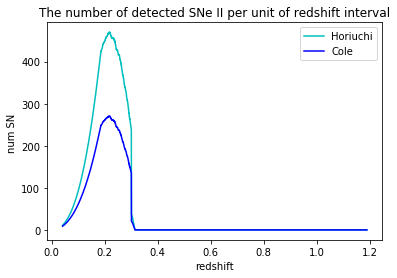

In [18]:


########################################################################################################################

########################################
#              dN/dz                   #
########################################

########################################################################################################################

dV_dz_dW=np.zeros(len(z_random))
dn_dz_Horiuchi=np.zeros(len(z_random))  # Madau model 1
n_Horiuchi=[0]*len(z_random)
dn_dz_Cole=np.zeros(len(z_random)) # Madau model 2
n_Cole=[0]*len(z_random)
# The number of detected SNe II per unit of redshift interval is    

for i in range(len(z_random)):
    dV_dz_dW[i]=(pow(r_com_LCDM(z_random[i]),2)*d_h*e_z_LCDM(z_random[i]))    #dV(z) is the volume per unit redshift being surveyed
    dn_dz_Horiuchi[i]=(SNR_Horiuchi(z_random[i])*1.0/(1+z_random[i])*dV_dz_dW[i]*delta_omega)#dn/dz is the SN per unit of redshift, comovil volume, solid angle and fied of view
    dn_dz_Cole[i]=(SNR_Cole(z_random[i])*1.0/(1+z_random[i])*dV_dz_dW[i]*delta_omega)#dn/dz is the SN per unit of redshift, comovil volume, solid anfle and fied of view


    n_Horiuchi[i]=dn_dz_Horiuchi[i]*((delta_t_SN_tot[i])*1.0/365.25) #In yr (SNR in yr)
    n_Cole[i]=dn_dz_Cole[i]*((delta_t_SN_tot[i])*1.0/365.25)
                               

z_random,n_Horiuchi,n_Cole = zip(*sorted(zip(z_random,n_Horiuchi,n_Cole)))

plt.plot(z_random,np.array(n_Cole),'c',z_random,np.array(n_Horiuchi),'b')
plt.title('The number of detected SNe II per unit of redshift interval')
plt.xlabel('redshift')
plt.ylabel('num SN ')
plt.legend(('Horiuchi','Cole'))
plt.show()


In [19]:
# We integrate for all the redshift to have the number of SN

z_tot_Horiuchi=[]

z_tot_Cole=[]

for i in range(len(z_random)):
    for j in range((int(round(n_Horiuchi[i],0)))):
        z_tot_Horiuchi.append(z_random[i])
    for j in range((int(round(n_Cole[i],0)))):
        z_tot_Cole.append(z_random[i])

#plt.hist(z_tot_Horiuchi,color='blue',alpha=0.9,label='Horiuchi')
#plt.hist(z_tot_Cole,color='red',alpha=0.5,label='Cole')
#plt.xlabel('redshift')
#plt.ylabel('SN ')
#plt.savefig('LSST_distri_1.png')
#plt.show()


m_SN=np.zeros((N_SNe,len(z_random)))
Pd_SN=np.zeros((N_SNe,len(z_random)))
delta_t_SN=np.zeros((N_SNe,len(z_random)))

for i in range(len(z_random)):
    #m_SN[:,i]=mu_LCDM(z_random[i])+Mabs_V_rand+KV_func(z_random[i])
    m_SN[:,i]=mu_LCDM(z_random[i])+Mabs_V_rand+Krr_func(z_random[i])
    Pd_SN[:,i]=Pd_rand*(1+z_random[i])

for j in range((N_SNe)):
    for i in range(len(z_random)):
        if z_random[i]<=0.3: #avant z=0.3 le V->r
            if m_SN[j,i]<mag_lim_10[1]:
                delta_t_SN[j,i]=Pd_SN[j,i]

        elif (z_random[i]>0.3) and (z_random[i]<0.57) : #avant z>0.3 z<0.57 le V->i
            if m_SN[j,i]<mag_lim_10[2]:
                delta_t_SN[j,i]=Pd_SN[j,i]
        elif (z_random[i]>0.56) and (z_random[i]<0.78) : #avant z>0.3 z<0.57 le V->z
            if m_SN[j,i]<mag_lim_10[3]:
                delta_t_SN[j,i]=Pd_SN[j,i]
        elif (z_random[i]>0.77) : #avant z>0.78 le V->Y
            if m_SN[j,i]<mag_lim_10[4]:
                delta_t_SN[j,i]=Pd_SN[j,i]

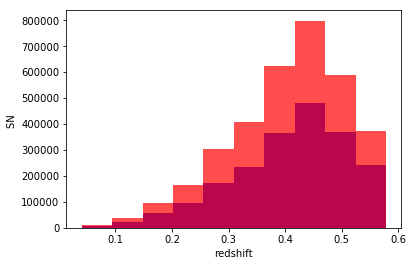

In [ ]:
delta_t_SN_tot=np.zeros((len(z_random)))
for i in range(len(z_random)):
    delta_t_SN_tot[i]=sum(delta_t_SN[:,i])

delta_t_SN_tot=delta_t_SN_tot*1.0/N_SNe

dV_dz_dW=np.zeros(len(z_random))
dn_dz_Horiuchi=np.zeros(len(z_random))  # Madau model 1
n_Horiuchi=[0]*len(z_random)
dn_dz_Cole=np.zeros(len(z_random)) # Madau model 2
n_Cole=[0]*len(z_random)
# The number of detected SNe II per unit of redshift interval is    

for i in range(len(z_random)):
    dV_dz_dW[i]=(pow(r_com_LCDM(z_random[i]),2)*d_h*e_z_LCDM(z_random[i]))    #dV(z) is the volume per unit redshift being surveyed
    dn_dz_Horiuchi[i]=(SNR_Horiuchi(z_random[i])*1.0/(1+z_random[i])*dV_dz_dW[i]*delta_omega)#dn/dz is the SN per unit of redshift, comovil volume, solid angle and fied of view
    dn_dz_Cole[i]=(SNR_Cole(z_random[i])*1.0/(1+z_random[i])*dV_dz_dW[i]*delta_omega)#dn/dz is the SN per unit of redshift, comovil volume, solid anfle and fied of view

    n_Horiuchi[i]=dn_dz_Horiuchi[i]*((delta_t_SN_tot[i])*1.0/365.25) #In yr (SNR in yr)
    n_Cole[i]=dn_dz_Cole[i]*((delta_t_SN_tot[i])*1.0/365.25)
                               
z_random,n_Horiuchi_10,n_Cole_10 = zip(*sorted(zip(z_random,n_Horiuchi,n_Cole)))

z_tot_Horiuchi_10=[]
z_tot_Cole_10=[]

for i in range(len(z_random)):
    for j in range((int(round(n_Horiuchi_10[i],0)))):
        z_tot_Horiuchi_10.append(z_random[i])
    for j in range((int(round(n_Cole_10[i],0)))):
        z_tot_Cole_10.append(z_random[i])
        
plt.hist(z_tot_Horiuchi_10,color='blue',alpha=0.9,label='Horiuchi')
plt.hist(z_tot_Cole_10,color='red',alpha=0.7,label='Cole')
plt.xlabel('redshift')
plt.ylabel('SN ')
##plt.savefig('LSST_distri_1.png')
plt.show()

In [ ]:

'''

On fait le diagramme de Hubble en utilisant cette distribution et en prenant 10 000

'''

N_SNe_HD=input("Number of SNe for the Hubble diagram: ")
ind_SNe=np.random.choice(np.array(ind_tot)[(np.array(Mabs_V_MC)<-15.0) & (np.array(Mabs_V_MC)>-17.0)], N_SNe, replace=True)
z_SNe_HD=np.random.choice(z_tot_Horiuchi, N_SNe_HD, replace=True)

plt.hist(z_SNe_HD,color='blue',alpha=0.9,label='Single-visit')
plt.legend(loc=1,markerscale=0.5,prop={'size':12},ncol=2)
plt.xlabel('redshift')
plt.ylabel('SN ')
plt.tick_params(axis='both', which='major', labelsize=13)
#plt.savefig('../../../Redaction_these/Tesis_Finale/Figures/SCM/LSST_distri_5000.png')
plt.show()


### Better way to apply Kcor

In [ ]:
c26202=np.loadtxt('c26202_stisnic_002.ascii')
lambda_c26202=c26202[:,0] #in AA
flux_c26202=c26202[:,1]   #
c26202_func=interpolate.interp1d(lambda_c26202,flux_c26202)

mag_c26202=[17.00,16.701,16.336,16.244,16.237,16.258] # u not real!


F_g_DES=integrate.simps(c26202_func(lambda_g_LSST)*g_func_LSST(lambda_g_LSST),lambda_g_LSST)
ZP_g_LSST=mag_c26202[0]+2.5*log10(F_g_DES)
F_r_DES=integrate.simps(c26202_func(lambda_r_LSST)*r_func_LSST(lambda_r_LSST),lambda_r_LSST)
ZP_r_LSST=mag_c26202[1]+2.5*log10(F_r_DES)
F_i_DES=integrate.simps(c26202_func(lambda_i_LSST)*i_func_LSST(lambda_i_LSST),lambda_i_LSST)
ZP_i_LSST=mag_c26202[2]+2.5*log10(F_i_DES)
F_z_DES=integrate.simps(c26202_func(lambda_z_LSST)*z_func_LSST(lambda_z_LSST),lambda_z_LSST)
ZP_z_LSST=mag_c26202[3]+2.5*log10(F_z_DES)
F_Y_DES=integrate.simps(c26202_func(lambda_Y)*Y_func_LSST(lambda_Y),lambda_Y)
ZP_Y=mag_c26202[4]+2.5*log10(F_Y_DES)

print ZP_g_LSST,ZP_r_LSST,ZP_i_LSST,ZP_z_LSST,ZP_Y

In [100]:

# Dessart modele at rest frame
Model=[str('m15_du_sch_mlt3_FeC_mix0p4_18.fl')]
epoque_model=51
txt=np.loadtxt('m15mlt3/%s'%Model[0]).transpose()
lambda_model=(txt[0])
flux_model=(txt[1])
F_spec_model_0=interpolate.interp1d(lambda_model,flux_model)

Kr_z=np.zeros(len(z_sim))

ZP_LSST=[47.0,47.0,47.0,47.0,47.0,47.0]     ## put the actual number
filter_func_tot=[u_func,g_func,r_func,i_func,z_func,y_func]
lambda_lsst_tot=[lambda_filter,lambda_filter,lambda_filter,lambda_filter,lambda_filter,lambda_filter]

LSST_names=['u','g','r','i','z','y']
lsst_effl=[3654.9,4800.3,6222.0,7540.6,8682.1,9916.6]
leffl=np.array(lsst_effl)


for  i in range(len(z_sim)):
    #move model at diferent redshifts
    lambda_model_obs=lambda_model*(1+z_sim[i])
    flux_model_obs=flux_model*1.0/(1+z_sim[i])
    F_spec_model_z=interpolate.interp1d(lambda_model_obs,flux_model_obs)

    #rest frame
    n_lsst=integrate.simps(F_spec_model_0(lambda_filter)*r_func(lambda_filter)*lambda_filter,lambda_filter)
    m_rest_r=-2.5*np.log10(n_lsst/(h_erg*c_AA))+ZP_LSST[2]   # r_band 

    #select the closest filter to r at a certain redshift
    lambda_eff=lsst_effl[2]*(1+z_sim[i]) #r
    ind_X=np.where(np.array(lsst_effl)==find_nearest(lsst_effl,lambda_eff))[0][0]
    
    if abs(lambda_eff-lsst_effl[ind_X])<1500:
        print 'Obs. filter: '+LSST_names[ind_X]+' -> Rest. filter: '+LSST_names[2]+' and z: '+str(z_sim[i])
        ZP_X=ZP_LSST[ind_X]
        X_func=filter_func_tot[ind_X]
        lambda_X=lambda_lsst_tot[ind_X]

        F_obs=integrate.simps(F_spec_model_z(lambda_X)*X_func(lambda_X),lambda_X)
        m_obs=-2.5*np.log10(F_obs)+ZP_X

        Kr_z[i]=(m_obs-m_rest_r)
    else:
        Kr_z[i]=np.NAN

Kr_func=interpolate.interp1d(z_sim,Kr_z)

Obs. filter: r -> Rest. filter: r and z: 0.04
Obs. filter: r -> Rest. filter: r and z: 0.05
Obs. filter: r -> Rest. filter: r and z: 0.06
Obs. filter: r -> Rest. filter: r and z: 0.07
Obs. filter: r -> Rest. filter: r and z: 0.08
Obs. filter: r -> Rest. filter: r and z: 0.09
Obs. filter: r -> Rest. filter: r and z: 0.1
Obs. filter: i -> Rest. filter: r and z: 0.11
Obs. filter: i -> Rest. filter: r and z: 0.12
Obs. filter: i -> Rest. filter: r and z: 0.13
Obs. filter: i -> Rest. filter: r and z: 0.14
Obs. filter: i -> Rest. filter: r and z: 0.15
Obs. filter: i -> Rest. filter: r and z: 0.16
Obs. filter: i -> Rest. filter: r and z: 0.17
Obs. filter: i -> Rest. filter: r and z: 0.18
Obs. filter: i -> Rest. filter: r and z: 0.19
Obs. filter: i -> Rest. filter: r and z: 0.2
Obs. filter: i -> Rest. filter: r and z: 0.21
Obs. filter: i -> Rest. filter: r and z: 0.22
Obs. filter: i -> Rest. filter: r and z: 0.23
Obs. filter: i -> Rest. filter: r and z: 0.24
Obs. filter: i -> Rest. filter: r an

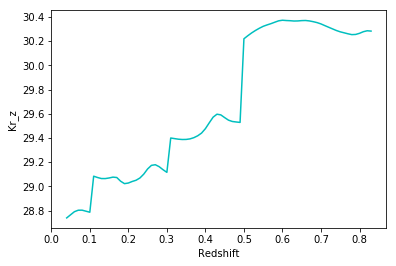

array([ 28.73885684,  28.76466228,  28.7902217 ,  28.80249457,
        28.80285716,  28.79436669,  28.78592237,  29.08366618,
        29.07299584,  29.06434775,  29.06400039,  29.06889926,
        29.07602585,  29.07279628,  29.04211355,  29.02213288,
        29.02722606,  29.04008396,  29.05015271,  29.06875621,
        29.10069788,  29.14355433,  29.17336051,  29.17852648,
        29.16234839,  29.13746868,  29.11549386,  29.39935894,
        29.3943115 ,  29.389497  ,  29.38704424,  29.38760849,
        29.39209023,  29.40207301,  29.41762749,  29.43998246,
        29.47650869,  29.52487537,  29.57152502,  29.59610477,
        29.59048538,  29.56794028,  29.54677647,  29.53588388,
        29.53181555,  29.52832936,  30.21953598,  30.24463972,
        30.26789401,  30.28833463,  30.30652546,  30.32248982,
        30.3340519 ,  30.34442704,  30.35630315,  30.36785151,
        30.37274491,  30.37033751,  30.36887331,  30.36631065,
        30.36706364,  30.369678  ,  30.37066185,  30.36

In [101]:
plt.plot(z_sim,Kr_z,'c')
plt.xlabel('Redshift')
plt.ylabel('Kr_z')
plt.show()
Kr_z